<a href="https://colab.research.google.com/github/jplineb/FASTWASON/blob/master/Watson_FAST_Model_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import plotly.plotly as py
import plotly.graph_objs as go


In [0]:
calib_frac = 0.25

## Load and prepare the data

In [0]:
df = pd.read_csv("FASTDataFrameNice.csv")
df.head()

,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual
0,0,video33327.mp4__frame176.png,1,0.907,0.001,0.000,0.000,0.000,1.001101
1,1,video33642.mp4__frame110.png,1,0.418,0.108,0.153,0.663,0.004,2.797177
2,2,video33642.mp4__frame66.png,1,0.891,0.017,0.031,0.035,0.000,1.188912
3,3,video33671.mp4__frame66.png,1,0.031,0.269,0.833,0.004,0.000,2.712401
4,4,video33671.mp4__frame88.png,1,0.010,0.898,0.035,0.001,0.000,2.028602


In [0]:
# pull off target and variable columns
y = df.actual_qual.values
X = df.iloc[:, 3:8].values
X[:5]

array([[0.907, 0.001, 0.   , 0.   , 0.   ],
       [0.418, 0.108, 0.153, 0.663, 0.004],
       [0.891, 0.017, 0.031, 0.035, 0.   ],
       [0.031, 0.269, 0.833, 0.004, 0.   ],
       [0.01 , 0.898, 0.035, 0.001, 0.   ]])

In [0]:
# get sample weights to balance quality levels
qual_counts = df.groupby("actual_qual")['actual_qual'].agg('count').values
print(qual_counts)
print(sum(qual_counts))
weights =  (234/5)/qual_counts
weights = weights**2
print(weights)
print(qual_counts/ sum(qual_counts) * weights)

def get_weight(qual):
  wt = weights[qual-1]
  return wt

get_weight(3)

y_weights = df.actual_qual.apply(get_weight)
print(y_weights)

[35 69 62 43 25]
234
[1.78795102 0.46003781 0.56978148 1.18455381 3.504384  ]
[0.26742857 0.13565217 0.15096774 0.21767442 0.3744    ]
0      1.787951
1      1.787951
2      1.787951
3      1.787951
4      1.787951
5      1.787951
6      1.787951
7      1.787951
8      1.787951
9      1.787951
10     1.787951
11     1.787951
12     1.787951
13     1.787951
14     1.787951
15     1.787951
16     1.787951
17     1.787951
18     1.787951
19     1.787951
20     1.787951
21     1.787951
22     1.787951
23     1.787951
24     1.787951
25     1.787951
26     1.787951
27     1.787951
28     1.787951
29     1.787951
         ...   
204    1.184554
205    1.184554
206    1.184554
207    1.184554
208    1.184554
209    3.504384
210    3.504384
211    3.504384
212    3.504384
213    3.504384
214    3.504384
215    3.504384
216    3.504384
217    3.504384
218    3.504384
219    3.504384
220    3.504384
221    3.504384
222    3.504384
223    3.504384
224    3.504384
225    3.504384
226    3.504384
2

In [0]:
df['Weights'] = y_weights
df.head()

,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights
0,0,video33327.mp4__frame176.png,1,0.907,0.001,0.000,0.000,0.000,1.001101,1.787951
1,1,video33642.mp4__frame110.png,1,0.418,0.108,0.153,0.663,0.004,2.797177,1.787951
2,2,video33642.mp4__frame66.png,1,0.891,0.017,0.031,0.035,0.000,1.188912,1.787951
3,3,video33671.mp4__frame66.png,1,0.031,0.269,0.833,0.004,0.000,2.712401,1.787951
4,4,video33671.mp4__frame88.png,1,0.010,0.898,0.035,0.001,0.000,2.028602,1.787951


In [0]:
# train/test split
# X_train, X_test, y_train, y_test, y_weights_train, _ = train_test_split(X, y, y_weights, test_size=1-calib_frac, stratify=y)
df_train, df_test = train_test_split(df, test_size=1-calib_frac, stratify=df.actual_qual)
print(df_train.shape)
df_test.head()

(58, 10)


,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights
100,100,video34526[1].mp4__frame44.png,2,0.359,0.028,0.803,0.000,0.000,2.373109,0.460038
126,126,video33547.mp4__frame88.png,3,0.000,0.000,0.893,0.066,0.004,3.076843,0.569781
29,29,video34513.mp4__frame44.png,1,0.907,0.001,0.000,0.000,0.000,1.001101,1.787951
54,54,video33642.mp4__frame44.png,2,0.874,0.127,0.027,0.005,0.001,1.193424,0.460038
176,176,video33663.mp4__frame22.png,4,0.000,0.101,0.875,0.045,0.008,2.961127,1.184554


In [0]:
# Split the train and test data set

### Test ###
y_dftest = df_test.actual_qual.values # is array
x_dftest = df_test.iloc[:, 3:8].values # is array


### Train ###
y_dftrain = df_train.actual_qual.values # is array
x_dftrain = df_train.iloc[:, 3:8].values # is array
y_dftrain_weights = df_train.Weights.values # is array
x_dftrain[1:3]


array([[0.001, 0.008, 0.862, 0.195, 0.003],
       [0.901, 0.03 , 0.   , 0.   , 0.   ]])

In [0]:
print(x_dftrain.shape)
print(x_dftest.shape)
print(y_dftrain.shape)
print(y_dftest.shape)
print(y_dftrain_weights.shape)

(58, 5)
(176, 5)
(58,)
(176,)
(58,)


## Train the calibration model

In [0]:
estim = LinearRegression(fit_intercept= False)
estim.fit(x_dftrain, y_dftrain, sample_weight=y_dftrain_weights)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [0]:
# evaluate the mode:

# look at fit coefs
print(estim.coef_)
# -> array([1.76293662, 2.13542102, 2.92516357, 3.10297302, 3.49912872])

[1.0933106  2.05243346 3.60871741 4.66683376 3.18399175]


## Get final scores

In [0]:
# evaluate model on training set
y_test_pred = estim.predict(x_dftest)

In [0]:
np.sqrt(mean_squared_error(y_dftest, y_test_pred))

1.2258035548718549

In [0]:
mean_absolute_error(y_dftest, y_test_pred)

0.947785627900341

In [0]:
df_eval = pd.DataFrame(x_dftest)
df_eval['y_test'] = y_dftest
df_eval['y_test_pred'] = y_test_pred
df_eval.head()

,0,1,2,3,4,y_test,y_test_pred
0,0.359,0.028,0.803,0.000,0.000,2,3.347767
1,0.000,0.000,0.893,0.066,0.004,3,3.543332
2,0.907,0.001,0.000,0.000,0.000,1,0.993685
3,0.874,0.127,0.027,0.005,0.001,2,1.340166
4,0.000,0.101,0.875,0.045,0.008,4,3.600403


In [0]:
df_fulltest = df_test.reset_index()
df_fulltest['calibration_predict'] = y_test_pred
df_fulltest.head()

,index,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights,calibration_predict
0,100,100,video34526[1].mp4__frame44.png,2,0.359,0.028,0.803,0.000,0.000,2.373109,0.460038,3.347767
1,126,126,video33547.mp4__frame88.png,3,0.000,0.000,0.893,0.066,0.004,3.076843,0.569781,3.543332
2,29,29,video34513.mp4__frame44.png,1,0.907,0.001,0.000,0.000,0.000,1.001101,1.787951,0.993685
3,54,54,video33642.mp4__frame44.png,2,0.874,0.127,0.027,0.005,0.001,1.193424,0.460038,1.340166
4,176,176,video33663.mp4__frame22.png,4,0.000,0.101,0.875,0.045,0.008,2.961127,1.184554,3.600403


In [0]:
# df_eval.groupby(y_test).apply(lambda x: np.sqrt(mean_squared_error(x.y_test, x.y_test_pred)))
meanerrorforclass = df_eval.groupby(y_dftest).apply(lambda x: mean_absolute_error(x.y_test, x.y_test_pred))



## Merge on img_name

In [0]:
df_quadrants = pd.read_csv("quadrant_confidence.csv") # loads in qudrants with img names csv
df_quadrants.head()


,Unnamed: 0,Unnamed: 0.1,actual_class,predicted_class,img_name,Quadrant
0,0,0,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.907}, {""cla...",video33327.mp4__frame176.png,unknown
1,1,0,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.907}, {""cla...",video33327.mp4__frame176.png,unknown
2,2,1,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.418}, {""cla...",video33642.mp4__frame110.png,unknown
3,3,1,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.418}, {""cla...",video33642.mp4__frame110.png,unknown
4,4,2,Quality 1,"[{""class"": ""Quality 1"", ""score"": 0.891}, {""cla...",video33642.mp4__frame66.png,unknown


In [0]:
dfquadcolumns = ["img_name", "Quadrant"]
df_quadrants = df_quadrants.reindex(columns = dfquadcolumns)
df_quadrants.head()

,img_name,Quadrant
0,video33327.mp4__frame176.png,unknown
1,video33327.mp4__frame176.png,unknown
2,video33642.mp4__frame110.png,unknown
3,video33642.mp4__frame110.png,unknown
4,video33642.mp4__frame66.png,unknown


In [0]:
df_final = df_fulltest.merge(df_quadrants, on = "img_name") # creates final data frame 
df_final.head()


,index,Unnamed: 0,img_name,actual_qual,Quality 1,Quality 2,Quality 3,Quality 4,Quality 5,predicted_qual,Weights,calibration_predict,Quadrant
0,100,100,video34526[1].mp4__frame44.png,2,0.359,0.028,0.803,0.000,0.000,2.373109,0.460038,3.347767,suprapubic
1,126,126,video33547.mp4__frame88.png,3,0.000,0.000,0.893,0.066,0.004,3.076843,0.569781,3.543332,suprapubic
2,29,29,video34513.mp4__frame44.png,1,0.907,0.001,0.000,0.000,0.000,1.001101,1.787951,0.993685,unknown
3,54,54,video33642.mp4__frame44.png,2,0.874,0.127,0.027,0.005,0.001,1.193424,0.460038,1.340166,left_upper_quadrant
4,54,54,video33642.mp4__frame44.png,2,0.874,0.127,0.027,0.005,0.001,1.193424,0.460038,1.340166,left_upper_quadrant


In [0]:
dffinalcolumns = ["img_name", "actual_qual", "Quality 1", "Quality 2", "Quality 3", "Quality 4", "Quality 5", "Weights", "predicted_qual", "calibration_predict", "Quadrant" ]
df_final = df_final.reindex(columns = dffinalcolumns)
df_final.head()
df_final.to_csv("Calibrated_Model_Predictions.csv")

## Get outputs

[3, 4, 1, 1, 1, 4, 4, 5, 5, 1, 1, 5, 5, 3, 5, 4, 4, 5, 3, 3, 5, 5, 2, 4, 3, 3, 4, 4, 2, 3, 2, 5, 2, 3, 2, 3, 2, 4, 4, 4, 2, 4, 5, 5, 4, 4, 4, 1, 4, 4, 3, 3, 3, 1, 1, 1, 4, 4, 3, 3, 3, 5, 5, 5, 5, 5, 2, 1, 3, 4, 3, 2, 2, 5, 3, 4, 3, 2, 2, 5, 5, 5, 3, 2, 4, 4, 3, 3, 3, 4, 3, 1, 5, 5, 3, 5, 5, 3, 4, 4, 5, 5, 3, 3, 3, 4, 3, 2, 2, 3, 5, 3, 3, 2, 5, 2, 5, 2, 2, 2, 5, 2, 2, 1, 1, 4, 4, 2, 2, 5, 5, 3, 3, 3, 3, 4, 4, 2, 5, 1, 4, 4, 3, 3, 3, 5, 5, 2, 1, 1, 4, 5, 3, 3, 5, 3, 3, 3, 3, 5, 5, 5, 1, 1, 4, 5, 1, 2, 2, 4, 4, 4, 5, 5, 2, 3, 5, 5, 1, 1, 4, 2, 3, 3, 4, 2, 5, 1, 1, 3, 3, 2, 2, 2, 4, 5, 4, 4, 2, 4, 2, 3, 3, 1, 4, 4, 4, 5, 5, 1, 4, 1, 4, 5, 2, 5, 5, 2, 2, 2, 4, 4, 1, 3, 3, 3, 2, 5, 4, 1, 3, 1, 5, 5]
Confusion matrix, without normalization
[[16  6  3  4  0]
 [ 9 23 21  9  5]
 [ 2 11 15 19 16]
 [ 0  1 15 12 19]
 [ 2  0  3  8 15]]


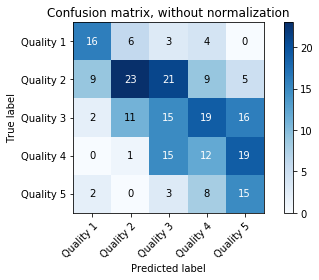

In [0]:
# confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  

CalQual = df_final["calibration_predict"].values.tolist()
i = 0
for x in CalQual:
  CalQual[i] = round(x)
  i = i + 1
  
print(CalQual) 
  
TruQual = df_final['actual_qual'].values.tolist()

a = plot_confusion_matrix(TruQual, CalQual, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5']) 
  
plt.savefig("confusion_matrix.png")  
  


In [0]:
# nice quality-level performance table


In [0]:
# quality-level performance by region

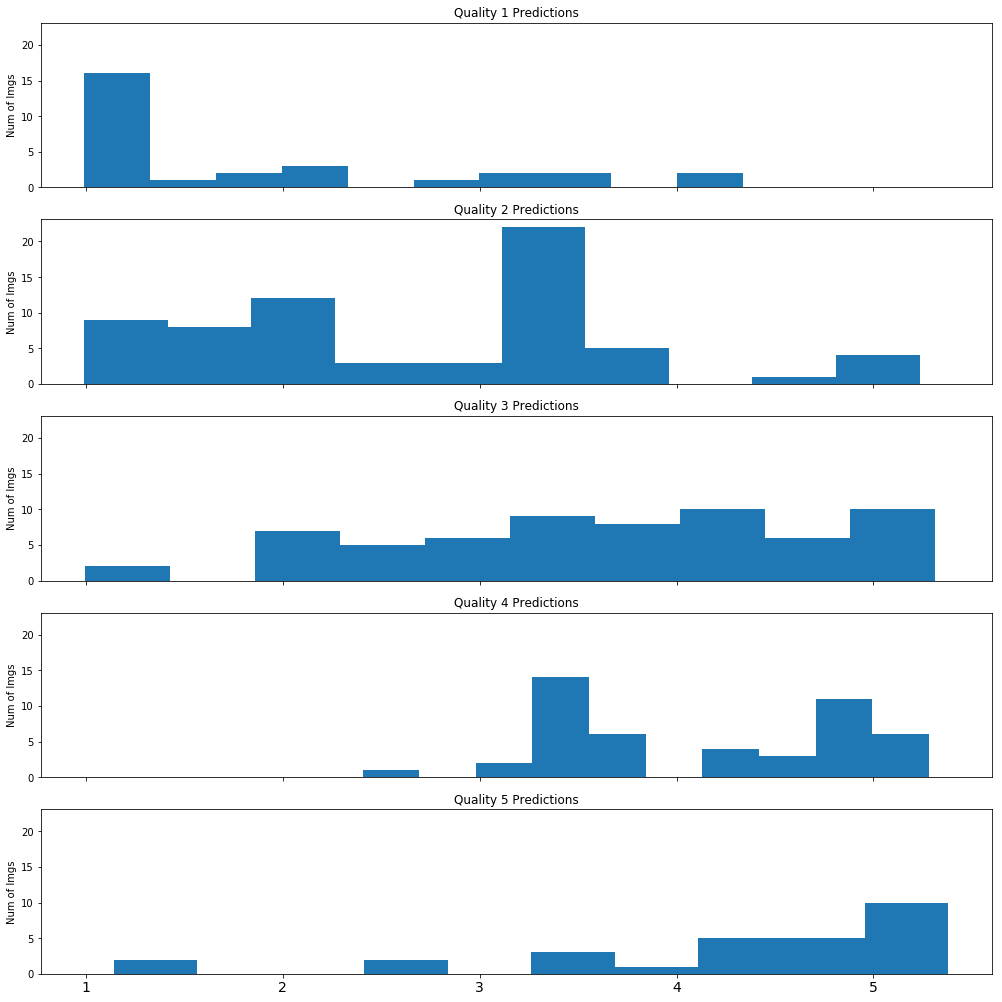

In [0]:
# Distribution of predication sfor each equality level 

fig, axarr = plt.subplots(5, sharex=True, sharey=True, figsize=(14,14))
for i in range(1,6):
 
  dfi = df_final.loc[df_final.actual_qual==i, ]
  ax = axarr[i-1]
  ax.hist(dfi['calibration_predict']);
  plottitle = "Quality " + str(i) + " Predictions"
  ax.set_title(plottitle)
  ax.set_ylabel('Num of Imgs')
  plt.setp(ax.get_xticklabels(), fontsize = 14)
  
  

# plt.xlim([0,1])
# plt.ylim([0,10])
plt.tight_layout(pad=1)
fig.show()
plt.savefig("Distribution_of_predictions_for_each_quality_level.png")
